In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm # Import cm module for color maps
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
from scipy.stats import linregress
from datetime import datetime

%matplotlib inline

# Impor the OpenWeatherMap API key
from config import api_key

In [ ]:
#Skip running this cell if your API limit is reached
#Variables used in API call, oldest date is furthest back we are willing to go
oldest_date = "2014-01-31"
company_ticker = ["TAN", "ENPH", "SEDG", "FSLR", "HYDR", "PLUG", "BLDP", "BE", "FAN", "TAC", "TPIC", "AMSC"]
time_function = "TIME_SERIES_MONTHLY"
base_url = "https://www.alphavantage.co/query?"

company_data = []

for ticker in company_ticker:
    finished_url = f"{base_url}function={time_function}&symbol={ticker}&apikey={api_key}"
    print(f"Processing {ticker}")

    result_data = requests.get(finished_url).json()

    time.sleep(1)

    for monthly in result_data["Monthly Time Series"]:
        monthly_date = time.strptime(monthly, "%Y-%m-%d")
        oldest = time.strptime(oldest_date, "%Y-%m-%d")
        if (monthly_date < oldest):
            continue
        stock_date = monthly
        stock_close = result_data["Monthly Time Series"][monthly]["4. close"]
        company_data.append({"Ticker":ticker,
                            "Date":stock_date,
                            "Closing Price":stock_close})

company_data_df = pd.DataFrame(company_data)
company_data_df['Date'] = pd.to_datetime(company_data_df['Date'])
company_data_df


In [ ]:
#Skip running this cell if your API limit is reached
#Add a type column and lable to each stock
company_data_df["Type"] = ""
company_data_df["Type"] = np.where(company_data_df["Ticker"] == "TAN", "Solar", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Ticker"] == "ENPH", "Solar", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Ticker"] == "SEDG", "Solar", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Ticker"] == "FSLR", "Solar", company_data_df["Type"])

company_data_df["Type"] = np.where(company_data_df["Ticker"] == "HYDR", "Hydrogen", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Ticker"] == "PLUG", "Hydrogen", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Ticker"] == "BLDP", "Hydrogen", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Ticker"] == "BE", "Hydrogen", company_data_df["Type"])

company_data_df["Type"] = np.where(company_data_df["Ticker"] == "FAN", "Wind", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Ticker"] == "TAC", "Wind", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Ticker"] == "TPIC", "Wind", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Ticker"] == "AMSC", "Wind", company_data_df["Type"])

#Save the Data pulled to a CSV file
company_data_df.to_csv("data/company_data.csv", index_label="Stock_ID") #change stock id 

In [2]:
#prep some lists for the later code to use
company_ticker = ["TAN", "ENPH", "SEDG", "FSLR", "HYDR", "PLUG", "BLDP", "BE", "FAN", "TAC", "TPIC", "AMSC"]
solar_tickers = ["TAN", "ENPH", "SEDG", "FSLR"]
hydrogen_tickers = ["BLDP", "PLUG", "BE", "HYDR"]
wind_tickers = ["FAN", "TAC", "TPIC", "AMSC"]
year_list = [i for i in range(2014, 2025)]

#Read data from the saved CSV file and sort it by Ticker and date
read_data_df = pd.read_csv("data/company_data.csv", index_col="Stock_ID") #change stock id
read_data_df['Date'] = pd.to_datetime(read_data_df['Date'])
ordered_data_df = read_data_df.sort_values(by=["Ticker", "Date"])
ordered_data_df

,Ticker,Date,Closing Price,Type
Stock_ID,,,,
1355,AMSC,2014-01-31,1.50,Wind
1354,AMSC,2014-02-28,1.85,Wind
1353,AMSC,2014-03-31,1.61,Wind
1352,AMSC,2014-04-30,1.28,Wind
1351,AMSC,2014-05-30,1.40,Wind
...,...,...,...,...
1133,TPIC,2024-05-31,5.48,Wind
1132,TPIC,2024-06-28,3.99,Wind
1131,TPIC,2024-07-31,4.26,Wind


In [3]:
# Function to plot graphs showing stock prices
def plot_stock_prices(tickers, given_data_df, type):
    plt.figure(figsize=(8, 6))
    
    # Define colors
    colors = cm.viridis(np.linspace(0, 1, len(tickers)))
   

    for i, ticker in enumerate(tickers):
        stock_data = given_data_df[given_data_df["Ticker"] == ticker]
        
        # Plot Original Data
        plt.plot(stock_data["Date"], stock_data["Closing Price"], label=ticker, color=colors[i])

        # Calculate and plot moving average
        stock_data["Moving_Avg"] = stock_data["Closing Price"].rolling(window=30).mean()
        plt.plot(stock_data["Date"], stock_data["Moving_Avg"], linestyle='--', label=f"{ticker} - MA", color=colors[i])

    # Add annotation for key events (IRA Passed)
    # Get the current y-axis limits and place the annotation at 80% of the y-limit
    ax = plt.gca()  # Get current axis
    y_min, y_max = ax.get_ylim()  # Get y-axis limits
    y_annotate = y_max * 0.8  # Place annotation at 80% of the y-axis

    # Add annotation for key events (IRA Passed)
    plt.annotate('IRA Passed', 
             xy=(mdates.datestr2num('2022-08'), y_annotate),  # where the arrow points (lower position)
             xytext=(mdates.datestr2num('2021-12'), y_annotate + 20),  # position of the text (higher than arrow)
             arrowprops=dict(facecolor='black', arrowstyle="->", shrinkA=0, shrinkB=5),  # Adjusted arrow style
             fontsize=10, ha='center')
   

    # Shaded region for COVID-19
    plt.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2021-03'), color='gray', alpha=0.3, label='COVID-19')

    plt.title(f"Stock Prices for {type} Companies")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Minor ticks every month
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"graphs/{type}–stocks_austin.png")
    plt.show()



/var/folders/2z/wq9630lx4dl17_8c406wvh7r0000gn/T/ipykernel_42712/1060923446.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Moving_Avg"] = stock_data["Closing Price"].rolling(window=30).mean()
/var/folders/2z/wq9630lx4dl17_8c406wvh7r0000gn/T/ipykernel_42712/1060923446.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Moving_Avg"] = stock_data["Closing Price"].rolling(window=30).mean()
/var/folders/2z/wq9630lx4dl17_8c406wvh7r0000gn/T/ipykernel_42712/1060923446.py:16: SettingWi

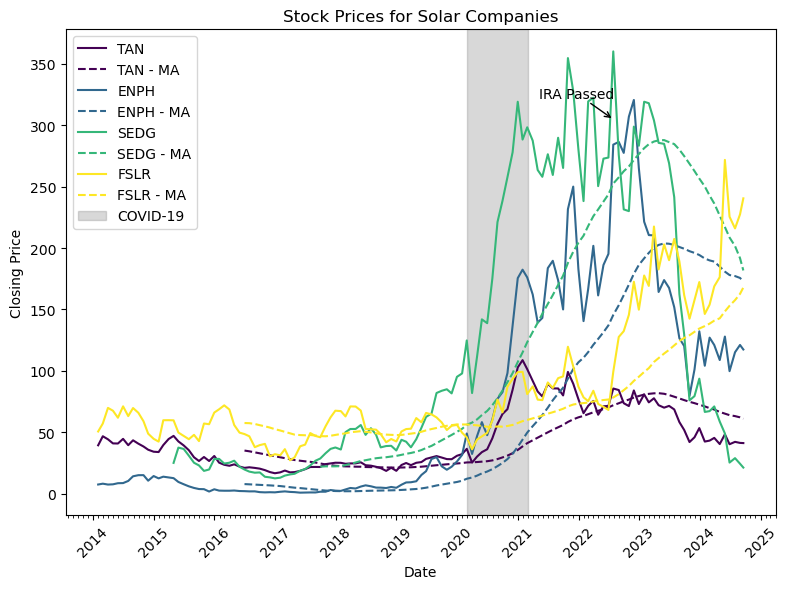

In [4]:
# Plot Stocks for each company type
plot_stock_prices(solar_tickers, ordered_data_df, "Solar")

/var/folders/2z/wq9630lx4dl17_8c406wvh7r0000gn/T/ipykernel_42712/1060923446.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Moving_Avg"] = stock_data["Closing Price"].rolling(window=30).mean()
/var/folders/2z/wq9630lx4dl17_8c406wvh7r0000gn/T/ipykernel_42712/1060923446.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Moving_Avg"] = stock_data["Closing Price"].rolling(window=30).mean()
/var/folders/2z/wq9630lx4dl17_8c406wvh7r0000gn/T/ipykernel_42712/1060923446.py:16: SettingWi

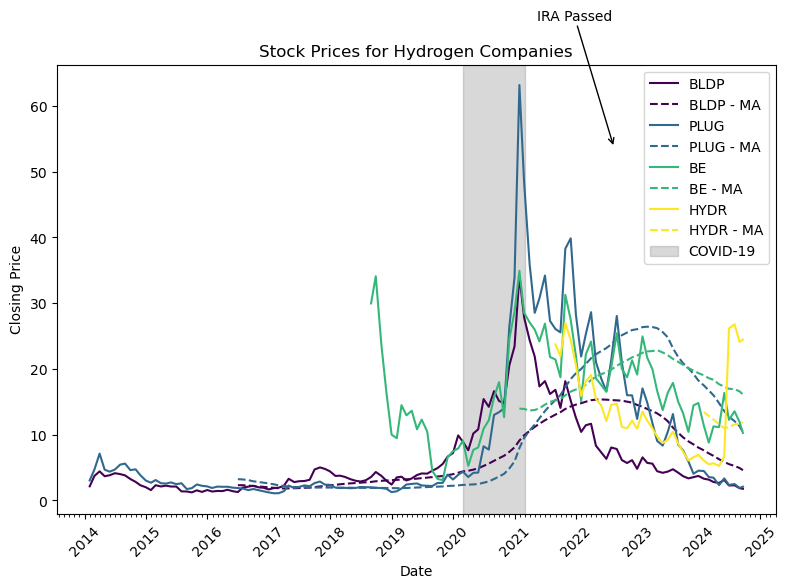

In [5]:
plot_stock_prices(hydrogen_tickers, ordered_data_df, "Hydrogen")

/var/folders/2z/wq9630lx4dl17_8c406wvh7r0000gn/T/ipykernel_42712/1060923446.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Moving_Avg"] = stock_data["Closing Price"].rolling(window=30).mean()
/var/folders/2z/wq9630lx4dl17_8c406wvh7r0000gn/T/ipykernel_42712/1060923446.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Moving_Avg"] = stock_data["Closing Price"].rolling(window=30).mean()
/var/folders/2z/wq9630lx4dl17_8c406wvh7r0000gn/T/ipykernel_42712/1060923446.py:16: SettingWi

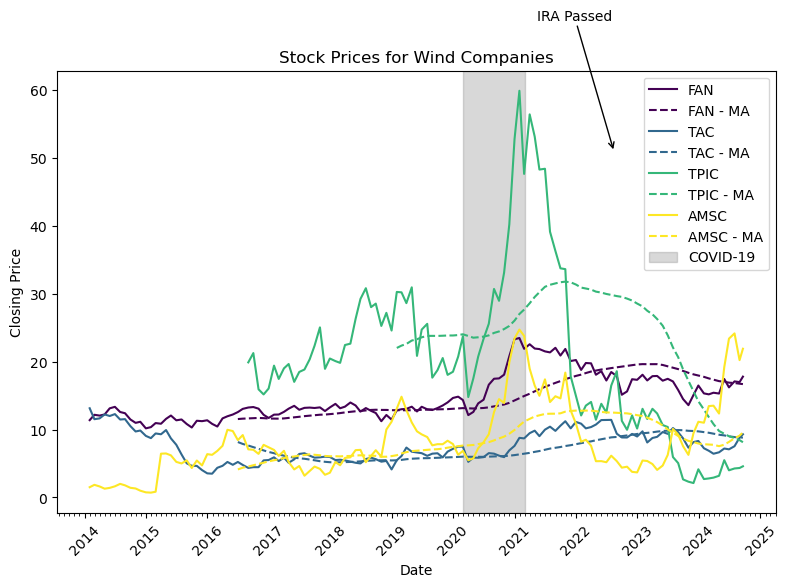

In [6]:
plot_stock_prices(wind_tickers, ordered_data_df, "Wind")